### **SECTION 1: SANITATION DATA**


This section describes the process of loading, processing and transformation of the available raw data into the shape and form suitable for clustering algorithms.

### SECTION 1.1: UPLOAD OF DATA TO GOOGLE COLAB

The data collected consists of 244 rows (points), each of which has 7 columns (features). The 7 features are:

1. Timestamp
2. GPS coordinates
3. Type of infrastructure component/features of interest
4. Rate the sanitary state of the identified feature
5. What is the main source of drinking water in the area?	
6. Are water treatment methods observed in the area?
7. If yes, what water treatment method is used? If no, why?

The first step in the analysis of the data was to upload a file called **sanitation_data.csv** from a local computer to Google Colab using Colab's library as show below (commented out because data had been uploaded to Google Colab at the time of writing this report):



In [725]:
########## LEAVE THIS COMMENTED BECAUSE THE FILE HAS BEEN UPLOADED ##########
#from google.colab import files
#sanitation_data = files.upload()
#elevations_json_data = files.upload()

### SECTION 1.2: PANDAS DATAFRAME

The data from **sanitation_data.csv** was read and converted into Pandas Data Frame using the Pandas library as shown below:

In [726]:
import pandas as pd
sanitation_data = pd.read_csv("sanitation_data.csv")

### SECTION 1.3: REMOVAL OF TIMESTAMP COLUMN

The first column of the **sanitation_data** dataframe obtained in SECTION 1.2 contained **Timestamp** column which were removed as follows:

In [727]:
sanitation_data = sanitation_data.drop(["Timestamp"],axis=1)

### SECTION 1.4: DECOUPLING OF GPS COORDINATES

The **GPS Coordinates** column of the sanitation data was in the form of a string **"latitude, longitude"**. This form of representation was decoupled into separate numerical **latitude** and **longitude** columns as follows:

In [728]:
temp= sanitation_data[['GPS coordinates']]
lat_long_sanitation=pd.DataFrame()
lat_long_sanitation[['latitude','longitude']] = temp['GPS coordinates'].str.split(',',expand=True).astype(float)

### SECTION 1.5: DREMOVAL OF GPS COORDINATES COLUMN
The **GPS Coordinates** column was then removed from the dataframe as follows:

In [729]:
sanitation_data = sanitation_data.drop(['GPS coordinates'], axis=1)
#print(sanitation_data.head())

At this point, there are two Pandas dataframes.

The **sanitation_data** with the following columns:

1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?

The **lat_long_sanitation** with the following columns:

1. latitude
2. longitude

### SECTION 1.6: INSERTION OF ELEVATION COLUMN INTO lat_long_sanitation

The **GPS Coordinates** column described in SECTION 1.4 resulted into only two separate numerical columns for latitudes and longitudes. A third column, called **elevation**, which contained heights at the corresponding longitudes and latitudes was added with the help of [Google's Point Elevation API](https://developers.google.com/maps/documentation/elevation/overview). The API simply returns a json file with the heights for each latitude-longitude pair. This file was renamed to **elevations_data.json**. The following code shows how this API can be used.

In [730]:
temp=lat_long_sanitation.to_csv(header=None, index=False).split('\n')
lat_long_API = '|'.join([str(elem) for elem in temp]) 
lat_long_API = lat_long_API[0:-1]
#print(lat_long_API)
#https://maps.googleapis.com/maps/api/elevation/json?locations=lat_long_API&key=YOUR_API_KEY

The file **elevations_data.json** was uploaded to Google Colab in SECTION 1.1 along with **sanitation_data.csv**

All the elevations from **elevations_data.json** were loaded into **elevations** list as follows:

In [731]:
import json

with open('elevations_data.json') as f:
  elevations_data = json.load(f)

elevations = []

for i in elevations_data["results"]:
  elevations.append(i.get("elevation"))

The elevations of the **elevations** list were joined with the latitudes and longitudes of the **lat_long_sanitation** dataframe to form **lat_long_ele_sanitation** dataframe as follows:

In [732]:
lat_long_ele_sanitation = lat_long_sanitation
lat_long_ele_sanitation["elevation"] = elevations

### SECTION 1.7: TRANSFORMATION OF LATITUDES, LONGITUDES, AND ELEVATIONS INTO X, Y,  Z COORDINATES

By this point, there are three Pandas dataframes. 

The **sanitation_data** with the following columns:
1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?


The **lat_long_sanitation** with the following columns:
1. latitude
2. longitude

and the **lat_long_elev_sanitation** with the following columns:
1. latitude
2. longitude
3. elevation


Since the latitudes, longitudes, and elevations are angular measurements, they can't be linearly scalled to produce meaningul results in clustering algorithms such as **K-means**, which is one of the clustering algorithms to be covered in SECTION 2.

### SECTION 1.7.1: GEODETIC TO ECEF CONVERSION

One of the common ways of converting latitudes ($\phi$), longitudes ($\lambda$), and elevation ($h$) from their polar form to their linear/cartesian form (X,Y,Z) is called Geodetic to ECEF (acronym for earth-centered, earth-fixed) conversion.

In this conversion, we have:

$X = (N(\phi)+h)cos(\phi)cos(\lambda)$

$Y = (N(\phi)+h)cos(\phi)sin(\lambda)$

$Z = \left(\frac{b²}{a²}N(\phi)+h \right)sin(\phi)$

Where:

$N(\phi)=\frac{a}{\sqrt{1-e^{2}sin^2\phi}}$ and $e^{2}=1-\frac{b^2}{a^2}$

and

$a=6378137.0 m$

$b=6356752.314245 m m$

The following code implements the above set of equations to transform the polar coordinates in **lat_long_ele_sanitation** dataframe to their linear/cartesian equivalent in the **X_Y_Z** dataframe.

In [733]:
import math


a=6378137.0
b=6356752.314245
e_squared=1-(b**2)/(a**2)

# Latitude (deg), Longitude (deg), Elevation (meters)
def geodetic_to_ecef(latitude,longitude,elevation):
    
    lamb = math.radians(latitude)
    phi = math.radians(longitude)
    h=elevation



    Nphi=a/math.sqrt(1-e_squared*(math.sin(lamb))**2)

    sin_lambda = math.sin(lamb)
    cos_lambda = math.cos(lamb)
    sin_phi = math.sin(phi)
    cos_phi = math.cos(phi)

    X = (Nphi+h) * cos_lambda * cos_phi
    Y = (Nphi+h) * cos_lambda * sin_phi
    Z = (((1 - e_squared) * Nphi)+h)* sin_lambda

    return X,Y,Z

X_Y_Z=lat_long_ele_sanitation.apply(lambda row:geodetic_to_ecef(row["latitude"],row["longitude"],row["elevation"]), axis=1)

# Convert the series to Pandas DataFrame
X_Y_Z = X_Y_Z.to_frame()
X_Y_Z = pd.DataFrame(X_Y_Z[0].to_list(), columns=['X','Y','Z'])


#print(X_Y_Z)
#print(sanitation_data)

### SECTION 1.7.2: COMBINING TRANSFORMED COORDINATES WITH REST OF DATA

The following code shows the joining of **X_Y_Z** dataframe to **sanitation_data** dataframe to form the **xyz_sanitation_data** dataframe that has the basic form for clustering in SECTION 2.

In [734]:
x_y_z_sanitation_data = pd.DataFrame()
x_y_z_sanitation_data = pd.concat([X_Y_Z,sanitation_data], axis=1)
#print(x_y_z_sanitation_data)

======================================================================================================================================================================================================================================

# SECTION 2: DATA CLUSTERING
This section aims to leverage on some of the popular clustering algorithms available today to determine if there is any relationship between the different variables of the sanitation data provided. This section will also take a look at possible spacial distribution of different data points.

### SECTION 2.1: GOWER'S SIMILARITY MATRIX 

Since the transformed data, **xyz_sanitation_data** (SECTION 1.7.2), contains both numerical and categorical information, it may not be apparent which of the variables are similar, or disimilar. **Gower's matrix** computes the similarities/disimilarities of mixed variables (numerical and categorical) in data by calculating all the pair-wise distances between every data point within the data.
Gower's similarity matrix can therefore be applied to **xyz_sanitation_data** dataframe since X, Y, Z and the "Rate the sanitary state" are numerical, while the rest of the variables are categorical.

A 0 distance means the variable(s) are 100% similar (distance to itself), and a 1 means the variables are 100% disimilar (the opposite).

In other words, the closer the Gower's score is close to 0, the higher the similarity between the variables, and therefore, these variables are more likely to be grouped or clustered together.



### SECTION 2.1.1: APPLICATION OF GOWER'S MATRIX ON SANITATION DATA

This section will take a look at potential application of the Gower's Similarity Matrix on the data provided.
The code below installs and imports gower and other libraries.

In [735]:
####################################################################
print("********************************************")
!pip install gower
print("********************************************")
import gower
import numpy as np
####################################################################

********************************************
********************************************


A single line of code using the gower library on the **xyz_sanitation_data** dataframe is all that is needed to produce a 244x244 square matrix (since there are 244 data points as mentioned in SECTION 1.1). The leading diagonal of the reulting square matrix are all 0s (because the data point calculates distance to itself). Below is the code:

In [736]:
####################################################################
similarity_matrix=gower.gower_matrix(x_y_z_sanitation_data)
print(similarity_matrix)
####################################################################

[[0.         0.142777   0.4622949  ... 0.41503987 0.44185585 0.32222214]
 [0.142777   0.         0.47530717 ... 0.43821704 0.34030977 0.21023442]
 [0.4622949  0.47530717 0.         ... 0.6273348  0.6124841  0.23492724]
 ...
 [0.41503987 0.43821704 0.6273348  ... 0.         0.276816   0.612262  ]
 [0.44185585 0.34030977 0.6124841  ... 0.276816   0.         0.4724113 ]
 [0.32222214 0.21023442 0.23492724 ... 0.612262   0.4724113  0.        ]]


The 244 data points in the dataset can be ranked according to their Gower scores. The lower the score, the higher the similarity. The following function ranks the data points according to their Gower scores, starting from lowest to highest. The function also returns the actual scores of the data points.

In [737]:
####################################################################
gower_scores=gower.gower_topn(similarity_matrix, n = 244)
print(gower_scores)
####################################################################

{'index': array([  0,  78,  11,  12,   1,   4,   5, 126,  10,  16, 228,  37, 128,
       129, 162, 173, 110, 135,  80,  60,  74,  47, 118,  62, 181,  68,
        63,  27,  18, 176, 232,   9, 124, 177, 188,  61,  54,  64, 206,
       198, 113,  46,   3, 186, 189,  72, 187,  79, 197, 220, 239, 203,
       182, 172, 204,  57,  59,   2,  84, 199, 193,  75, 132, 192, 144,
        58, 217, 218, 215, 243, 137, 216, 127, 195, 160, 202, 184, 166,
       230, 229, 227, 143, 174, 196, 147,  22, 210,  55, 200, 178, 165,
        69, 201,  67, 194, 205, 185, 190, 240, 213, 171, 209,  65,  85,
       231, 211, 154, 208,  92,  43,  95, 180, 207, 221,  45,  53, 238,
       226, 183, 170, 225,  71,   6,  82, 169,  73,  52,  66, 223, 106,
        77,  94,  50,  32,  31,  30,  70, 161,  99, 116,  17, 242, 149,
       107, 179, 115, 234,  98, 175, 241, 153, 212, 236, 148, 233, 105,
       112, 191,  33, 111, 157, 164, 159, 222, 219, 158,  76, 163, 235,
        56,  51,  44, 121, 237, 150,  89, 151, 134, 13

The following code displays a histogram of the Gower scores such that the left-most scores represent the most similar data points, and the right-most scores represent the most dissimilar data points. The histogram shows that Gower scores range from 0 to about 0.30

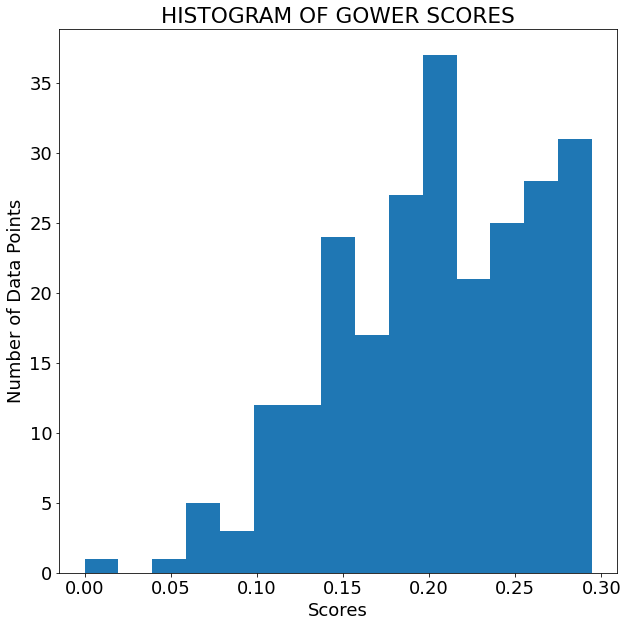

In [738]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})
plt.hist(gower_scores["values"], bins=15)
plt.title('HISTOGRAM OF GOWER SCORES')
plt.xlabel('Scores')
plt.ylabel('Number of Data Points')
plt.show()

The next code shows the first 10 most siilar data points in **xyz_sanitation_data** dataframe

In [739]:
idx = gower_scores["index"]

lowest_10 = idx[1:11]
print("*************************************")
for i in lowest_10:
  print(x_y_z_sanitation_data.loc[i,:])
  print("*************************************")

  

*************************************
X                                                                  5.10917e+06
Y                                                                   3.8177e+06
Z                                                                      -154740
Type of infrastructure component/features of interest       Water storage tank
Rate the sanitary state of the identified feature                            5
What is the main source of drinking water in the area?           Bottled water
Are water treatment methods observed in the area?                           NO
If yes, what water treatment method is used? If no, why?    Its borehole water
Name: 78, dtype: object
*************************************
X                                                                     5.10937e+06
Y                                                                     3.81745e+06
Z                                                                         -154632
Type of infrastructure

From the above output, and using Gower's similary scores, we can conclude that

A) Water storage tanks, Public / shared toilers, and Community water points are likely to be grouped/clustered together.

B) Tap water and Storage tank are more likely to be grouped/clustered together

C) In this cluster, "NO" is the most common answer to the question "Are water treatment methods observed in the area?" 

D) The answer "NO" in (C) above is due to ignorance

======================================================================================================================================================================================================================================

### SECTION 2.1.2: RELATION BETWEEN SANITATION RATES AND OTHER VARIABLES

This section will take a look at the following cases:

CASE1: SANITARY STATE VS TYPE OF INFRASTRUCTURE OF INTEREST

CASE2: SANITARY STATE VS MAIN SOURCE OF DRINKING WATER

CASE3: SANITARY STATE VS OBSERVATION OF WATER TREATMENT METHODS

CASE4: SANITARY STATE VS WATER TREATMENT METHOD OR WHY WATER TREATMENT WAS NOT OBSERVED

### SECTION 2.1.2.1: CASE1: SANITARY STATE VS TYPE OF INFRASTRUCTURE OF INTEREST

The following code groups all possibilities in the data set that show the relationship between sanitary state and the Type of infrastructure.

In [740]:
rate_infrastructure = pd.DataFrame()
rate_infrastructure = x_y_z_sanitation_data[["Rate the sanitary state of the identified feature","Type of infrastructure component/features of interest"]]
rate_infrastructure.groupby(["Rate the sanitary state of the identified feature","Type of infrastructure component/features of interest"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,Type of infrastructure component/features of interest,count
0,1,Manhole,3
1,1,Open water bodies,11
2,1,Public/shared toilets,6
3,1,Run off water/sewer line,13
4,1,Solid waste site,13
5,1,Tap water,1
6,1,Water storage tank,1
7,2,Open water bodies,4
8,2,Public/shared toilets,2
9,2,Run off water/sewer line,10


**From the above results, we can see that:**

**Run off water/sewer lines and Solid waste sites in areas with open water bodies are perceived as least sanitary. The least sanitary site has the highest number of the aforementioned types of infrastructures.** 



======================================================================================================================================================================================================================================

### SECTION 2.1.2.2: CASE2: SANITARY STATE VS MAIN SOURCE OF DRINKING WATER

The following code groups all possibilities in the data set that show the relationship between sanitary state and the main source of drinking water.

In [741]:
rate_water = pd.DataFrame()
rate_water = x_y_z_sanitation_data[["Rate the sanitary state of the identified feature","What is the main source of drinking water in the area?"]]
r_w=rate_water.groupby(["Rate the sanitary state of the identified feature","What is the main source of drinking water in the area?"]).size().reset_index().rename(columns={0:'count'})
lst_sanitary_state=r_w["Rate the sanitary state of the identified feature"].to_list()
lst_type_water = r_w["What is the main source of drinking water in the area?"].to_list()
lst_count= r_w["count"].to_list()

print("Sanitary State | Water Type (count)")
print("______________________________________________")
for i in range(len(lst_sanitary_state)):
  print(lst_sanitary_state[i],"             |",lst_type_water[i], "(",lst_count[i],")")

Sanitary State | Water Type (count)
______________________________________________
1              | Borehole ( 4 )
1              | Borehole water ( 1 )
1              | Borohol ( 1 )
1              | Bottled water ( 1 )
1              | Bottled water  ( 1 )
1              | Community water point ( 1 )
1              | Community water tank ( 1 )
1              | Community water tank  ( 1 )
1              | Kanjo water  ( 1 )
1              | Non ( 1 )
1              | Non  ( 2 )
1              | None ( 1 )
1              | Running tap ( 1 )
1              | Storage tank ( 3 )
1              | Storage water tank ( 1 )
1              | Tap ( 3 )
1              | Tap water ( 11 )
1              | Tap water  ( 1 )
1              | Tap/kanjo  ( 1 )
1              | Water vendor ( 2 )
1              | borehole ( 1 )
1              | bottled ( 2 )
1              | piped ( 1 )
1              | run off ( 1 )
1              | run off water ( 1 )
1              | tap water ( 3 )
2              | 

**From the above output, it is inconclusive as to how the type of drinking water affects the sanitation rate.**

======================================================================================================================================================================================================================================

### SECTION 2.1.2.3: CASE3: SANITARY STATE VS OBSERVATION OF WATER TREATMENT METHODS

The following code groups all possibilities in the data set that show the relationship between sanitary state and whether or not water treatment methods are osberved

In [742]:
rate_observation = pd.DataFrame()
rate_observation = x_y_z_sanitation_data[["Rate the sanitary state of the identified feature","Are water treatment methods observed in the area?"]]
rate_observation.groupby(["Rate the sanitary state of the identified feature","Are water treatment methods observed in the area?"]).size().reset_index().rename(columns={0:'count'})

,Rate the sanitary state of the identified feature,Are water treatment methods observed in the area?,count
0,1,NO,33
1,1,YES,15
2,2,NO,14
3,2,YES,15
4,3,NO,14
5,3,YES,21
6,4,NO,10
7,4,YES,38
8,5,NO,11
9,5,YES,30


**From the above table, it can be concluded that generally, the more people observe water treatment methods, the higher the sanitation state**

======================================================================================================================================================================================================================================

### SECTION 2.1.2.4: CASE4: SANITARY STATE VS WATER TREATMENT METHOD OR WHY WATER TREATMENT WAS NOT OBSERVED

The following code groups all possibilities in the data set that show the relationship between sanitary state and the water treatment method used, or why water treatment methods were not observed.

In [743]:
rate_method_reason = pd.DataFrame()
rate_method_reason = x_y_z_sanitation_data[["Rate the sanitary state of the identified feature","If yes, what water treatment method is used? If no, why?"]]
r_m_r=rate_method_reason.groupby(["Rate the sanitary state of the identified feature","If yes, what water treatment method is used? If no, why?"]).size().reset_index().rename(columns={0:'count'})
lst_sanitary_state=r_m_r["Rate the sanitary state of the identified feature"].to_list()
lst_method_reason = r_m_r["If yes, what water treatment method is used? If no, why?"].to_list()
lst_count= r_m_r["count"].to_list()

print("Sanitary State | Method/Reason (count)")
print("_________________________________________")
for i in range(len(lst_sanitary_state)):
  print(lst_sanitary_state[i],"             |",lst_method_reason[i], "(",lst_count[i],")")


Sanitary State | Method/Reason (count)
_________________________________________
1              | Boiling ( 2 )
1              | Boiling water ( 1 )
1              | Chlorinating ( 1 )
1              | Chlorination ( 1 )
1              | Chlorine ( 1 )
1              | Chlorine treatment  ( 1 )
1              | City council treated  ( 1 )
1              | Council  ( 1 )
1              | Decantation ( 1 )
1              | Direct from the tap.   ( 1 )
1              | Floating sewarage water ( 1 )
1              | Ignorance ( 10 )
1              | Lack of awareness ( 1 )
1              | No storage tanks ( 1 )
1              | No tanks ( 1 )
1              | No water point observed ( 1 )
1              | None ( 3 )
1              | None  ( 1 )
1              | Not aware ( 1 )
1              | Not sure if treated ( 1 )
1              | Not sure says its from the city council ( 1 )
1              | The vendor is unaware ( 1 )
1              | There are none ( 1 )
1              | They drin

**From the above results, Highest sanitary state of the water is achieved when more people use Chlorination as their treatment method.**

======================================================================================================================================================================================================================================

### SECTION 2.2: SPATIAL DISTRIBUTION OF THE DATA

This section will take a look at how various types of infrastructures are spatially ditributed based on their sanitary level. The section will also take a look at areas with high or low sanitary states.




### SECTION 2.2.1: SPATIAL DISTRIBUTION OF SANITARY INFRASTRUCTURE POINTS

The data contains 7 unique sanitation states [ 1, 2, 3, 4, 5, 6, 7 ], 1 being the least sanitary state, and 7 being the most sanitary state. The code below shows how the unique states in the data can be revealled

In [744]:
unique_staes = sanitation_data["Rate the sanitary state of the identified feature"].unique()
print(np.sort(unique_staes))

[1 2 3 4 5 6 7]


The next exercise is to observe the groupings of sanitary infrastrutures with the states 1 and 7. 

From CASE1 in SECTION 2.1.2.1, it was observed that the Run-off water / sewer lines and Solid Waste sites were the largest contributors to poor sanitary state of 1. On the other hand, more Water Storage Tanks were found in places with higher sanitary states such as 6 and 7. 

The following code will locate and plot low sanitary and high sanitary water infrastructures.

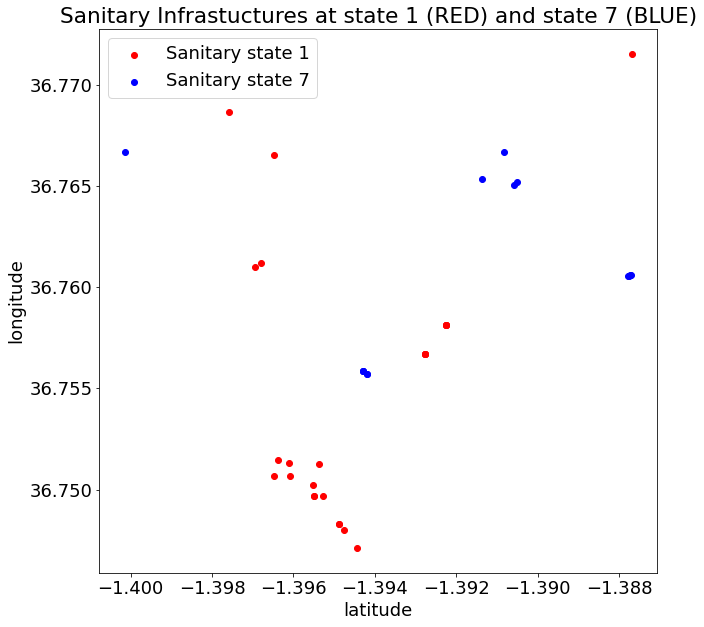

In [745]:
# Get the indices for level 1 sanitary state at Run off water/sewer line" and "Solid waste site"
sanitary_infrastructure_level1=[]

for i in range(244):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==1):
    if(sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Run off water/sewer line" or sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Solid waste site"): 
      sanitary_infrastructure_level1.append(i)


# Get the indices for level 7 sanitary state at "Water storage tank"
sanitary_infrastructure_level7=[]
for i in range(244):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==7):
    if(sanitation_data.loc[i,"Type of infrastructure component/features of interest"]=="Water storage tank"): 
      sanitary_infrastructure_level7.append(i)


level1_coordinates = lat_long_ele_sanitation.loc[sanitary_infrastructure_level1,"latitude":"longitude"].to_numpy()
level7_coordinates = lat_long_ele_sanitation.loc[sanitary_infrastructure_level7,"latitude":"longitude"].to_numpy()


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

ax = plt.gca()
P1=ax.scatter(level1_coordinates[:,0], level1_coordinates[:,1], color="r")
P2=ax.scatter(level7_coordinates[:,0], level7_coordinates[:,1], color="b")
ax.legend([P1,P2],["Sanitary state 1","Sanitary state 7"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Sanitary Infrastuctures at state 1 (RED) and state 7 (BLUE)")
plt.show()


      





From the Figure above, it can be seen that the Sanitary Infrastructures with low sanitary state (RED-State 1) mostly occur in clusters geographically. In this case they are clustered in the WEST of the area of interest area (South with respect to the plot. Note the direction of latitudes and longitudes).

On the other hand, Sanitary Infrastructures with high sanitary state (BLUE- State 7) are fewer and less clustered.

======================================================================================================================================================================================================================================

### SECTION 2.2.2: SPATIAL DISTRIBUTION OF LOW AND HIGH SANITARY STATES

While SECTION 2.2.1 focused on the distribution of the least and most sanitary infrastructures, this section will take a look at a wider picture. Here, low sanitary states will be regarded as states 1 and 2. High sanitary states will be regarded as staets 6 and 7. In both cases, the sanitary infrastructures won't be taken into account.

This section is more or less a more general case of SECTION 2.2.2. The following code locates all the states in question and diplay them on a plot.

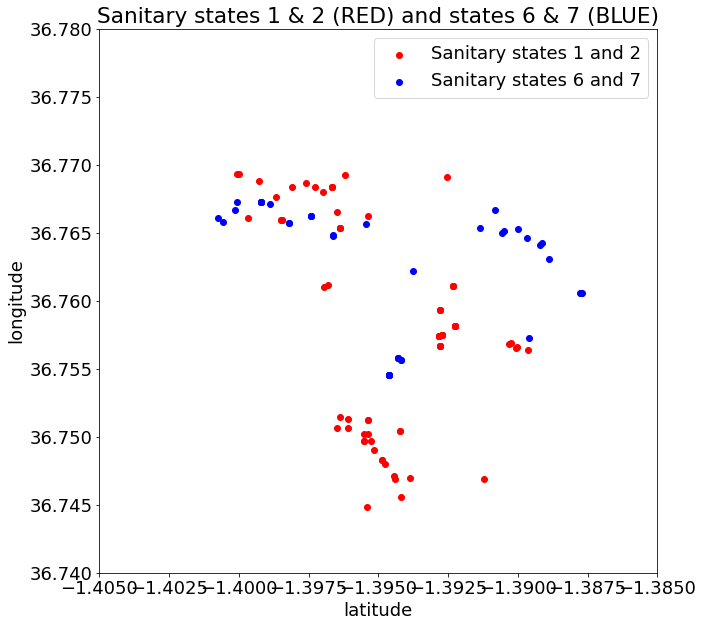

In [746]:
sanitary_level1_2=[]

for i in range(242):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==1 or sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==2):
    sanitary_level1_2.append(i)



sanitary_level6_7=[]

for i in range(242):
  if(sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==6 or sanitation_data.loc[i,"Rate the sanitary state of the identified feature"]==7):
    sanitary_level6_7.append(i)

level1_2_coordinates = lat_long_ele_sanitation.loc[sanitary_level1_2,"latitude":"longitude"].to_numpy()
level6_7_coordinates = lat_long_ele_sanitation.loc[sanitary_level6_7,"latitude":"longitude"].to_numpy()

ax = plt.gca()
P1=ax.scatter(level1_2_coordinates[:,0], level1_2_coordinates[:,1], color="r")
P2=ax.scatter(level6_7_coordinates[:,0], level6_7_coordinates[:,1], color="b")
ax.legend([P1,P2],["Sanitary states 1 and 2","Sanitary states 6 and 7"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Sanitary states 1 & 2 (RED) and states 6 & 7 (BLUE)")
plt.ylim((36.74, 36.78))
plt.xlim((-1.405, -1.385))
plt.show()

The above plot shows that the low santary states 1 and 2 appear in more dense clusters with the densest clusters located in the WEST of the target area (South with respect to the plot) and Central-East of the target area. The higher sanitary states are less dense and less numerous.

======================================================================================================================================================================================================================================

### SECTION 2.3: K-MEANS

This section will take  look at how the numerical information (latitudes, longitudes, elevations and sanitary states) of the dataset can be used to group the data points together.

K-means will be used for clustering as shown in the following code

In [747]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

# Get the X, Y, Z and Sanitary Rates
# X, Y, Z coordinates will be used instead of the polar coordinates due to scalling problems associated with polar coordinates

xyz_rates = x_y_z_sanitation_data[["X","Y","Rate the sanitary state of the identified feature"]].to_numpy()



# Standardize the columns
xyz_rates_standardized = (xyz_rates - np.mean(xyz_rates)) / np.std(xyz_rates)

lat_long_sanitation = lat_long_sanitation.to_numpy()

At this point, K-means is ready to start, however, it is good idea to determine the value of K before proceeding with clustering. The following code helps in finding the value of K. The optimum value is found at the **elbow** of the curve

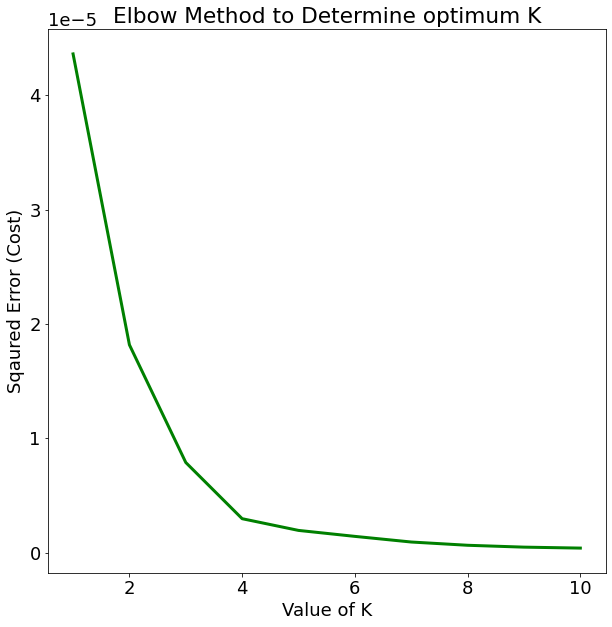

In [748]:
# Finding the value of K
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(xyz_rates_standardized) # USE STANDARDIZED DATA HERE
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.title("Elbow Method to Determine optimum K")
plt.show() 

From the above curve, the elbow is at K=3. The code below will proceed with K-means clustering of the data.

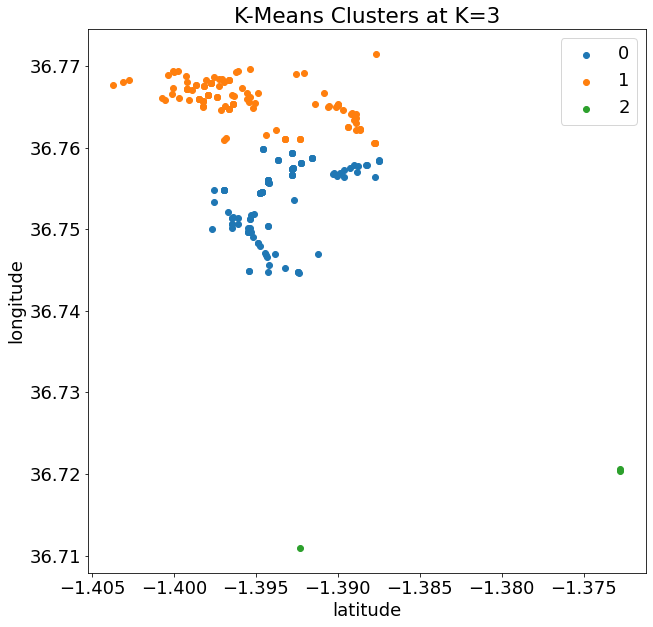

In [749]:
#####################################################################################
# BEGIN K-MEANS
#####################################################################################
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(xyz_rates_standardized) 
u_labels = np.unique(label)

fig = plt.figure()
for i in u_labels:
    plt.scatter(lat_long_sanitation[label == i , 0] , lat_long_sanitation[label == i , 1] , label = i) 
plt.legend()
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("K-Means Clusters at K=3")
plt.show()

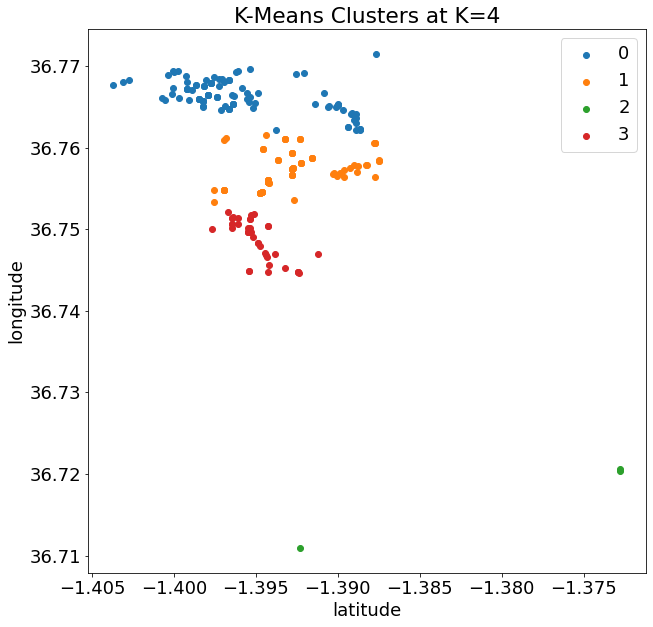

In [750]:
#####################################################################################
# BEGIN K-MEANS
#####################################################################################
kmeans = KMeans(n_clusters= 4)
label = kmeans.fit_predict(xyz_rates_standardized) 
u_labels = np.unique(label)

fig = plt.figure()
for i in u_labels:
    plt.scatter(lat_long_sanitation[label == i , 0] , lat_long_sanitation[label == i , 1] , label = i) 
plt.legend()
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("K-Means Clusters at K=4")
plt.show()

The above K-means plots at K= 3 and at K=4 are consitent with previous plots on sanitary states in SECTIONS 2.2.1 and 2.2.2. We can see that in all plots, the cluster centered at around latitude -1.395 and longitude 36.747.5 is entirely made up of sanitary states of 1 and 2. Furthermore, in all plots, the cluster centered at around latitude -1.390 and longitude 36.765 is entirely made up of sanitary states of 6 and 7. Therefore, the classification by K-means should more or less represent the grouping of the data points

======================================================================================================================================================================================================================================

# SECTION 3: SUMMARY OF RESULTS AND CONCLUSION

**SECTION 1**  talked about data proparation, formatting and transformation of polar coordinates (latitudes and longitudes) into cartesian coordinates X, and  Y via GEODETIC TO ECEF CONVERSION. This was necessary because polar values don't behave the same way as linear when scalled. This could inturn result in errors during clustering. The Section also discussed how using Google's Elevation API, elevations were added to the existing dataset (which originally had latitudes, longitudes, but not altitudes). However, this turned out to not be necessary for this project.

**SECTION 2** had 3 main parts - 2.1, 2.2 and 2.3
SECTION 2.1 was about Gower's Similarity Matrix and how it could be used to determine the most similar data points in the dataset. It can therefore be used to determine various datapoints which would be grouped together. Section 2.1 also looked at the Relation between Sanitary states and the rest of the variables. It was found that Run off  / sewage water and Solid waste cites were associated with low sanitary states of 1, especially in areas with Open water bodies. On the other hand, areas with higher sanitary states were found to have more water storage tanks and the absence of former. The type of drinking water could not determine the sanitary state. Last but not least, High sanitary states of 6 and 7 were found where people treated the water, mostly via Chlorination.

SECTION 2.2 was about Spatial distribution of infrastructures with least and highest sanitary states. It also looked at the general distribution of sanitary states on the map using the location coordinates.

**SECTION 2.3** demonstrated the use of K-means to determine clusters or groups of connected data points. It was found that the grouping was consistent with the spatial distribution of the various sanitary states in SECTION 2.2

